In [1]:
%pylab inline
from dolfin import *

Populating the interactive namespace from numpy and matplotlib


2


NameError: name 'bp' is not defined

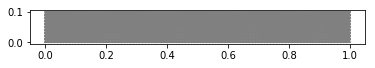

In [5]:
Lx,Ly =1.,0.1
nx = 100
ny = np.ceil(nx*Ly)
forced = 0
rho = 3150
b   = 0
rhob = Constant((0,rho*b))

E = 30e9
nu = 0.25
f = Constant((1e3,0))
d0 = 0.001

mesh = RectangleMesh(Point(0,0),Point(Lx,Ly),int(nx),int(ny))
# mesh = RectangleMesh(Point(0,0),Point(Lx,Ly),int(nx),int(ny))

boundaries = MeshFunction("size_t",mesh, mesh.topology().dim()-1)
plot(mesh)

#==========================;
# Define function spaces   ;
#==========================;
solSpace = VectorFunctionSpace(mesh,"CG",1)
#====================;
# Define functions   ;
#====================;
w = TestFunction(solSpace)

u = TrialFunction(solSpace)

#==============================;
# Identify the left boundary   ;
#==============================;
class left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0],0.0)

class right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near (x[0],Lx)
    
left = left()
right = right()

boundaries.set_all(0)
left.mark(boundaries,1)
right.mark(boundaries,2)

bcL = DirichletBC(solSpace,Constant((0.0,0.0)),left)

if (forced==0):
    bcR = DirichletBC(solSpace,Constant((d0,0.0)),right)
    bcs = [bcL,bcR]
else:
    bcs = [bcL] 

In [3]:
lmda = (E*nu) / ((1+nu)*(1 - (2*nu)))

mu = E/(2*(1+nu))

# Stress tensor
def sigma(r):
    return 2.0*mu*sym(grad(r)) + lmda*tr(sym(grad(r)))*Identity(len(r))

# Strain tensor
def epslon(r):
    return sym(grad(r))*Identity(len(r))

# Elastic stiffness form
def k(u, u_):
    return inner(sigma(u), sym(grad(u_)))*dx

ds = Measure("ds")[boundaries]


a = lmda * div(w) * div(u) * dx + mu * inner(grad(w),grad(u)+ grad(u).T) * dx
assemble(a)

if (forced==0):
    L = dot(w,rhob) * dx
else:
    L = dot(w,rhob) * dx + inner(f,w)*ds(2)

disp = Function(solSpace)

solve(a == L, disp, bcs)

stiffness = assemble(k(u,w))

stiffnessMatrix = stiffness.array()

ep = 0.5*np.matmul(disp.vector(),np.matmul(stiffnessMatrix,disp.vector()))

Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.


Energy:
 1605.62222612


Text(0.5, 1.0, 'Displacement')

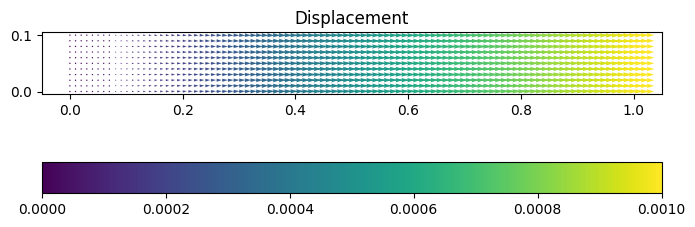

In [4]:
print("Energy:\n",ep)
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
p = plot(disp)
plt.colorbar(p,orientation="horizontal",fraction=0.07,anchor=(1.0,0.0))
plt.title('Displacement')